In [26]:
#import require python classes and packages
import os
import cv2
import numpy as np
from keras.utils.np_utils import to_categorical
from keras.layers import  MaxPooling2D
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D, BatchNormalization
from keras.layers import Convolution2D
from keras.models import Sequential
import pickle
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import keras
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix #class to calculate accuracy and other metrics
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [36]:
#define global variables
X = []
Y = []
path = "Dataset"
labels = []

In [37]:
#define function to load class labels
for root, dirs, directory in os.walk(path):
    for j in range(len(directory)):
        name = os.path.basename(root)
        if name not in labels:
            labels.append(name.strip())
def getLabel(name):
    index = -1
    for i in range(len(labels)):
        if labels[i] == name:
            index = i
            break
    return index
print("Accident Class Labels found in dataset : "+str(labels))

Accident Class Labels found in dataset : ['Hand', 'Head', 'Leg']


In [38]:
#loop and read all images from dataset
if os.path.exists('model/X.txt.npy'):#if images already processed then load all images
    X = np.load('model/X.txt.npy')
    Y = np.load('model/Y.txt.npy')
else:#if not processed then read and process each image
    X = []
    Y = []
    for root, dirs, directory in os.walk(path):
        for j in range(len(directory)):
            name = os.path.basename(root)
            if 'Thumbs.db' not in directory[j]:
                img = cv2.imread(root+"/"+directory[j])#read image
                img = cv2.resize(img, (64, 64))#resize image
                X.append(img)#addin images features to training array
                label = getLabel(name)
                Y.append(label)
    X = np.asarray(X)
    Y = np.asarray(Y)
    np.save('model/X.txt',X)
    np.save('model/Y.txt',Y)            
print("Dataset Loading Completed")
print("Total images found in dataset : "+str(X.shape[0])) 

Dataset Loading Completed
Total images found in dataset : 327


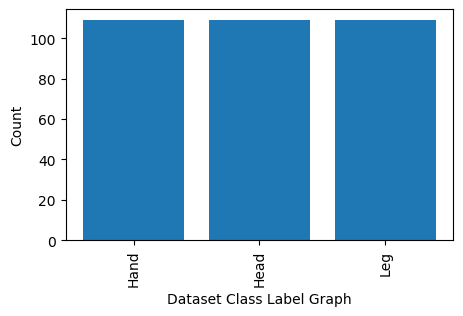

In [39]:
#visualizing class labels count found in dataset
names, count = np.unique(Y, return_counts = True)
height = count
bars = labels
y_pos = np.arange(len(bars))
plt.figure(figsize = (5, 3)) 
plt.bar(y_pos, height)
plt.xticks(y_pos, bars)
plt.xlabel("Dataset Class Label Graph")
plt.ylabel("Count")
plt.xticks(rotation=90)
plt.show()

In [40]:
#preprocess images like shuffling and normalization
X = X.astype('float32')
X = X/255 #normalized pixel values between 0 and 1
indices = np.arange(X.shape[0])
np.random.shuffle(indices) #shuffle all images
X = X[indices]
Y = Y[indices]
Y = to_categorical(Y)
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2) #split dataset into train and test
print("Dataset Image Processing & Normalization Completed")
print("80% images used to train algorithms : "+str(X_train.shape[0]))
print("20% image used to train algorithms : "+str(X_test.shape[0]))

Dataset Image Processing & Normalization Completed
80% images used to train algorithms : 261
20% image used to train algorithms : 66


In [41]:
#define global variables to save accuracy and other metrics
accuracy = []
precision = []
recall = []
fscore = []

In [42]:
def calculateMetrics(algorithm, predict, y_test):
    a = accuracy_score(y_test,predict)*100
    p = precision_score(y_test, predict,average='macro') * 100
    r = recall_score(y_test, predict,average='macro') * 100
    f = f1_score(y_test, predict,average='macro') * 100
    accuracy.append(a)
    precision.append(p)
    recall.append(r)
    fscore.append(f)
    print(algorithm+" Accuracy  :  "+str(a))
    print(algorithm+" Precision : "+str(p))
    print(algorithm+" Recall    : "+str(r))
    print(algorithm+" FScore    : "+str(f))    
    conf_matrix = confusion_matrix(y_test, predict) 
    plt.figure(figsize =(6, 3)) 
    ax = sns.heatmap(conf_matrix, xticklabels = labels, yticklabels = labels, annot = True, cmap="viridis" ,fmt ="g");
    ax.set_ylim([0,len(labels)])
    plt.title(algorithm+" Confusion matrix") 
    plt.xticks(rotation=90)
    plt.ylabel('True class') 
    plt.xlabel('Predicted class') 
    plt.show()    

CNN Algorithm Accuracy  :  100.0
CNN Algorithm Precision : 100.0
CNN Algorithm Recall    : 100.0
CNN Algorithm FScore    : 100.0


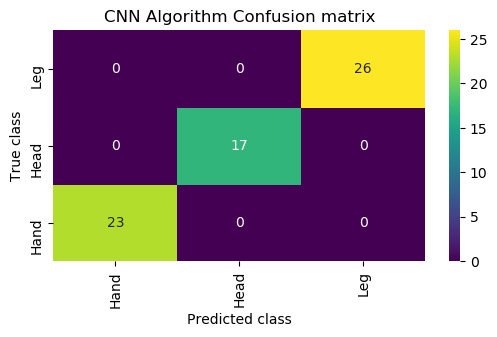

In [43]:
#train CNN algorithm on accident detection image features
cnn_model = Sequential()
#defining CNN layer with 32 filters of 3 X # matrix for features filtration
cnn_model.add(Convolution2D(32, (3 , 3), input_shape = (X_train.shape[1], X_train.shape[2], X_train.shape[3]), activation = 'relu'))
#max layer to collected relevant filtered features from Previous CNN layer
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
#defining another CNN layer for further features optimization
cnn_model.add(Convolution2D(32, (3, 3), activation = 'relu'))
#collect relevant features
cnn_model.add(MaxPooling2D(pool_size = (2, 2)))
#change features dimension to single dimension
cnn_model.add(Flatten())
#define output layer
cnn_model.add(Dense(units = 256, activation = 'relu'))
cnn_model.add(Dense(units = y_train.shape[1], activation = 'softmax'))
#compile, train and load model
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
if os.path.exists("model/cnn_weights.hdf5") == False:
    model_check_point = ModelCheckpoint(filepath='model/cnn_weights.hdf5', verbose = 1, save_best_only = True)
    hist = cnn_model.fit(X_train, y_train, batch_size = 32, epochs = 15, validation_data=(X_test, y_test), callbacks=[model_check_point], verbose=1)
    f = open('model/cnn_history.pckl', 'wb')
    pickle.dump(hist.history, f)
    f.close()    
else:
    cnn_model.load_weights("model/cnn_weights.hdf5")
#perform prediction on test images   
predict = cnn_model.predict(X_test)
predict = np.argmax(predict, axis=1)
y_test1 = np.argmax(y_test, axis=1)
#call this function to calculate accuracy and other metrics
calculateMetrics("CNN Algorithm", predict, y_test1)

SVM Algorithm Accuracy  :  95.45454545454545
SVM Algorithm Precision : 95.98765432098764
SVM Algorithm Recall    : 94.62915601023019
SVM Algorithm FScore    : 95.1600762745885


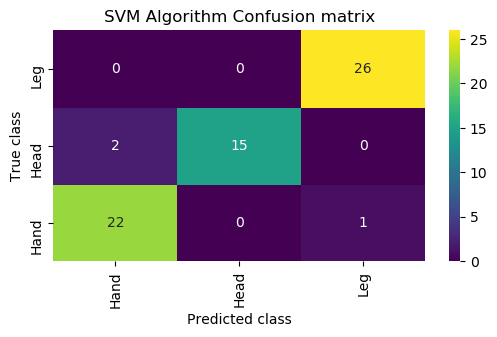

In [44]:
#reshaping images data to train with ML algorithms
y_train = np.argmax(y_train, axis=1)
y_test = np.argmax(y_test, axis=1)
X_train = np.reshape(X_train, (X_train.shape[0], (X_train.shape[1] * X_train.shape[2] * X_train.shape[3])))
X_test = np.reshape(X_test, (X_test.shape[0], (X_test.shape[1] * X_test.shape[2] * X_test.shape[3])))
X_train = X_train[0:1000]
X_test = X_test[0:1000]
#training svm on accident images features
svm_cls = svm.SVC()
svm_cls.fit(X_train, y_train)#training SVM on train features
predict = svm_cls.predict(X_test)#predicting on test features
#call this function to calculate accuracy and other metrics
calculateMetrics("SVM Algorithm", predict, y_test)

Decision Tree Algorithm Accuracy  :  66.66666666666666
Decision Tree Algorithm Precision : 66.96467783424303
Decision Tree Algorithm Recall    : 67.74214702603449
Decision Tree Algorithm FScore    : 66.5839243498818


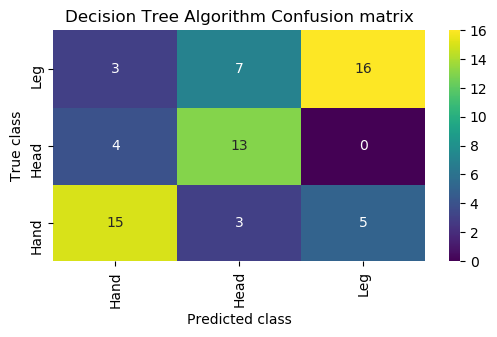

In [45]:
#training DecisionTreeClassifier on accident images features
dt_cls = DecisionTreeClassifier()
dt_cls.fit(X_train, y_train)#training DecisionTreeClassifier on train features
predict = dt_cls.predict(X_test)#predicting on test features
#call this function to calculate accuracy and other metrics
calculateMetrics("Decision Tree Algorithm", predict, y_test)

Random Forest Algorithm Accuracy  :  93.93939393939394
Random Forest Algorithm Precision : 94.05492836865386
Random Forest Algorithm Recall    : 93.85861367958555
Random Forest Algorithm FScore    : 93.9302010112221


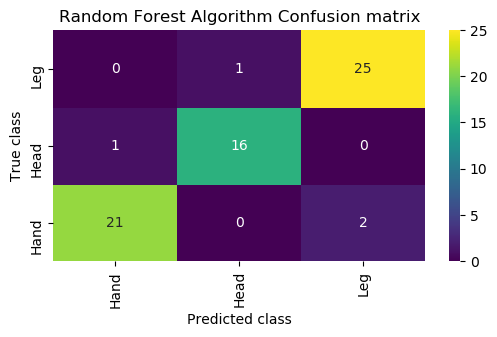

In [46]:
#training RandomForestClassifier on accident images features
rf_cls = RandomForestClassifier()
rf_cls.fit(X_train, y_train)#training RandomForestClassifier on train features
predict = rf_cls.predict(X_test)#predicting on test features
#call this function to calculate accuracy and other metrics
calculateMetrics("Random Forest Algorithm", predict, y_test)

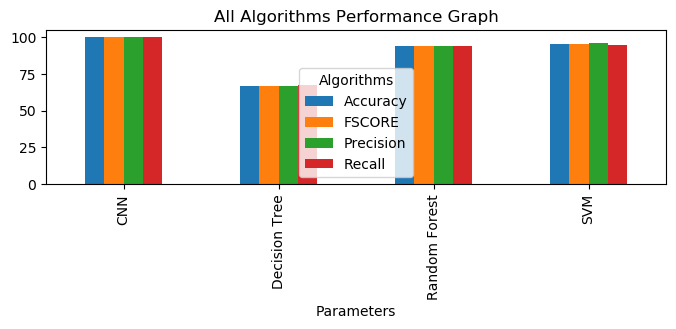

In [48]:
#comparison graph
import pandas as pd
df = pd.DataFrame([['CNN','Accuracy',accuracy[0]],['CNN','Precision',precision[0]],['CNN','Recall',recall[0]],['CNN','FSCORE',fscore[0]],
                   ['SVM','Accuracy',accuracy[1]],['SVM','Precision',precision[1]],['SVM','Recall',recall[1]],['SVM','FSCORE',fscore[1]],
                   ['Decision Tree','Accuracy',accuracy[2]],['Decision Tree','Precision',precision[2]],['Decision Tree','Recall',recall[2]],['Decision Tree','FSCORE',fscore[2]],
                   ['Random Forest','Accuracy',accuracy[3]],['Random Forest','Precision',precision[3]],['Random Forest','Recall',recall[3]],['Random Forest','FSCORE',fscore[3]],
                  ],columns=['Parameters','Algorithms','Value'])
df.pivot("Parameters", "Algorithms", "Value").plot(kind='bar', figsize=(8, 2))
plt.title("All Algorithms Performance Graph")
plt.show()

In [49]:
#display all algorithm performnace
algorithms = ['CNN', 'SVM', 'Decision Tree', 'Random Forest']
data = []
for i in range(len(accuracy)):
    data.append([algorithms[i], accuracy[i], precision[i], recall[i], fscore[i]])
data = pd.DataFrame(data, columns=['Algorithm Name', 'Accuracy', 'Precision', 'Recall', 'FSCORE'])
data   

,Algorithm Name,Accuracy,Precision,Recall,FSCORE
0,CNN,100.000000,100.000000,100.000000,100.000000
1,SVM,95.454545,95.987654,94.629156,95.160076
2,Decision Tree,66.666667,66.964678,67.742147,66.583924
3,Random Forest,93.939394,94.054928,93.858614,93.930201


In [51]:
def getSeverity(image_path):
    injury_type = "Unable to detect"
    img = cv2.imread(image_path)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    lower_red = np.array([0, 100, 120])
    upper_red = np.array([15, 255, 255])
    mask = cv2.inRange (hsv, lower_red, upper_red)
    contours, _ = cv2.findContours(mask.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) > 0:
        red_area = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(red_area)
        if w >= 100:
            injury_type = "Major Severity"
        else:
            injury_type = "Minor Severity"
        cv2.rectangle(img,(x, y),(x+w, y+h),(0, 0, 255), 2)
    return injury_type, img

In [52]:
def getRecommendation(label):
    with open("recommendation/"+label+".txt", "rb") as file:
        data = file.read()
    file.close()
    return data.decode()

In [53]:
#use this function to predict fish species uisng extension model
def predict(image_path):
    image = cv2.imread(image_path)#read test image
    img = cv2.resize(image, (64,64))#resize image
    im2arr = np.array(img)
    im2arr = im2arr.reshape(1,64,64,3)#convert image as 4 dimension
    img = np.asarray(im2arr)
    img = img.astype('float32')#convert image features as float
    img = img/255 #normalized image
    predict = cnn_model.predict(img)#perform prediction on test image
    predict = np.argmax(predict)
    injury_type, img = getSeverity(image_path)
    img = cv2.resize(img, (400,300))#display image with predicted output
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    recommendation = getRecommendation(labels[predict])
    print("Recommendation Details")
    print(recommendation)
    cv2.putText(img, 'Predicted As : '+labels[predict], (10, 25),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    cv2.putText(img, 'Injury Type : '+injury_type, (10, 55),  cv2.FONT_HERSHEY_SIMPLEX,0.7, (0, 0, 255), 2)
    plt.figure(figsize=(4,3))
    plt.imshow(img)

Recommendation Details
Best Hand & Face Trauma in Hyderabad - Harsha Hospitals
https://www.harshahospital.in ›
Plot No. 1, 76/1/b/4, Medchal Rd,
behind D-Mart Ganga Enclave,
Petbasheerabad, Caton Residential Twp,
Bolarum, Secunderabad, Telangana 500067


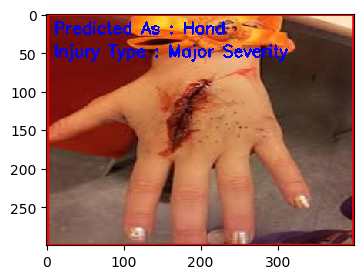

In [54]:
#call this function with input image to recommend hospital==================
predict("testImages/1.jpg")

Recommendation Details
Dr. (Col) Joy Dev Mukherji
Vice Chairman & Head- Neurology
Neurosciences, Neurology
Experience: 28+ Years
Gender: Male
Contact No: +91 92688 80303
Max Hospital, India


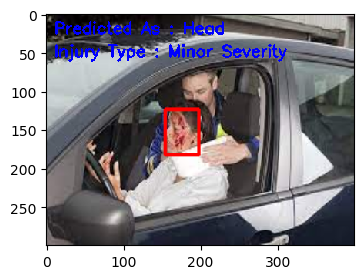

In [55]:
#call this function with input image to recommend hospital
predict("testImages/4.jpg")

Recommendation Details
Dr. (Col) Joy Dev Mukherji
Vice Chairman & Head- Neurology
Neurosciences, Neurology
Experience: 28+ Years
Gender: Male
Contact No: +91 92688 80303
Max Hospital, India


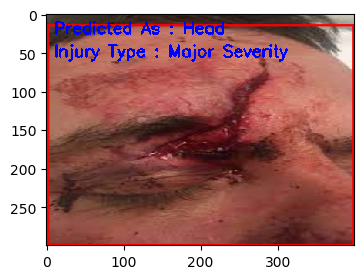

In [56]:
#call this function with input image to recommend hospital
predict("testImages/10.jpg")

Recommendation Details
Indraprastha Apollo Hospital, New Delhi
Apollo Hospitals, Greams Road, Chennai
Kokilaben Dhirubhai Ambani Hospital, Mumbai
Fortis Memorial Research Institute, Gurgaon
Manipal Hospital (Old Airport Road) Bangalore
Max Hospital


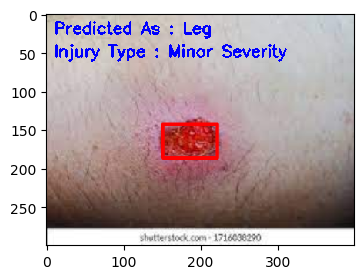

In [58]:
#call this function with input image to recommend hospital
predict("testImages/9.jpg")

Recommendation Details
Indraprastha Apollo Hospital, New Delhi
Apollo Hospitals, Greams Road, Chennai
Kokilaben Dhirubhai Ambani Hospital, Mumbai
Fortis Memorial Research Institute, Gurgaon
Manipal Hospital (Old Airport Road) Bangalore
Max Hospital


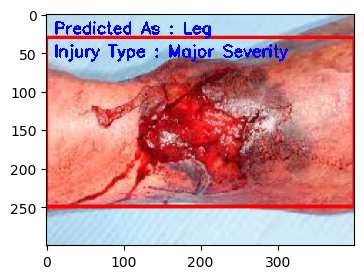

In [60]:
#call this function with input image to recommend hospital
predict("testImages/17.jpg")

Recommendation Details
Best Hand & Face Trauma in Hyderabad - Harsha Hospitals
https://www.harshahospital.in ›
Plot No. 1, 76/1/b/4, Medchal Rd,
behind D-Mart Ganga Enclave,
Petbasheerabad, Caton Residential Twp,
Bolarum, Secunderabad, Telangana 500067


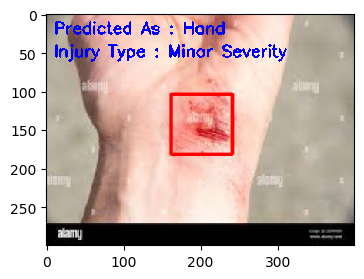

In [61]:
#call this function with input image to recommend hospital
predict("testImages/18.jpg")